In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.display import HTML, display
import os
import cv2
import numpy as np
from ipywidgets import widgets, Layout, interact
import pandas as pd

In [4]:
hide_me = ''
HTML('''<script>
code_show=true; 
function code_toggle() {
  if (code_show) {
    $('div.input').each(function(id) {
      el = $(this).find('.cm-variable:first');
      if (id == 0 || el.text() == 'hide_me') {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
    <input style="opacity:0" type="submit" value="Click here to toggle on/off the raw code.">
</form>''')

In [5]:
hide_me

path = widgets.Text()
print("Path: ")
display(path)

def handle_path(sender):
    global PATH
    PATH = path.value
    print("Path updated !")

Path: 


Text(value='')

## Reading data and creating ML dataframe

In [ ]:
from skimage.morphology import square
from skimage import io, color, filters, morphology, feature

def read_files(directory, limit):
    global PATH
    files_basic = []
    files=[]
    for file in os.listdir(directory):
        if limit <=0:
            break
        image_basic = io.imread(os.path.join(directory, file))
        files_basic.append(image_basic)
        image = cv2.imread(os.path.join(directory, file))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        files.append(image)
        limit-=1
    return files_basic, files

images_basic, images = read_files('data/images/', 2)
expected_results_basic, expected_results = read_files('data/manual1/', 2)
masks_basic, masks = read_files('data/mask/', 2)

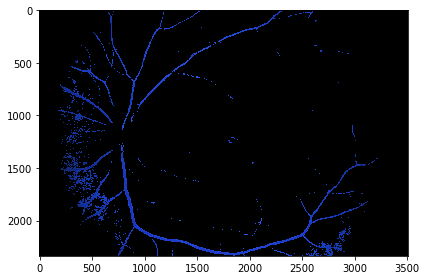

In [14]:
for i in range(0,len(images_basic) - 1):
    mask_gray = color.rgb2gray(masks_basic[i])
    
    for w in range(images[i].shape[1]):
        for h in range(images[i].shape[0]):            
            images[i][h, w][1] = min(int(images[i][h, w][1]*1.5), 255)
            
    image_hsv = cv2.cvtColor(images[i], cv2.COLOR_BGR2HSV)
    
    lower_red = np.array([0, 190, 100])
    upper_red = np.array([7, 255, 255])
    mask = cv2.inRange(image_hsv, lower_red, upper_red)
    
    imgRed = cv2.bitwise_and(images[i], images[i], mask=mask)
    
    io.imshow(imgRed)

In [7]:
def process_image(img):
    #normalizacja histogramu kolorów
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    res = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)
    #rozmycie
    res = cv2.medianBlur(res,7)
    return res


"""img = images[0]
filtered = process_image(img)

cv2.imshow("original", img)
cv2.imshow("filtered", filtered)
cv2.waitKey(0)
cv2.destroyAllWindows()"""


images=[process_image(img) for img in images]

error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\core\src\alloc.cpp:55: error: (-4:Insufficient memory) Failed to allocate 24556032 bytes in function 'cv::OutOfMemoryError'


In [6]:
def split_image(img,exp, width, height):
    img_width = img.shape[0]
    img_height = img.shape[1]
    tiles = [img[x:x+width,y:y+height] for x in range(0,img_width,width) for y in range(0,img_height,height)]
    values =[exp[x,y] for x in range(width//2,img_width,width) for y in range(height//2,img_height,height)]
    return tiles, values


In [7]:
def get_data(img):
    variance=np.var(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    huMoments = cv2.HuMoments(moments)
    result = [variance, moments, huMoments]
    return result


img=images[0]
fragments, values=split_image(img,expected_results[0], 7, 7)
data=[]
for frag in fragments:
    data.append(get_data(frag))


10.52765051598871


In [10]:
def createDataFrame(data):
    final_frame = pd.DataFrame()
    idx = ['hu0','hu1','hu2','hu3','hu4','hu5','hu6']
    for example in data:
        df1 = pd.DataFrame.from_dict(data = example[1], orient='index')
        df2 = pd.DataFrame.from_dict(data = {"variance":example[0]}, orient ='index') 
        df3 = pd.DataFrame(example[2],index=idx)
        frame = df2.append(df1.append(df3))
        frame = frame.T
        #print("FRAME ###########")
        #print(frame)
        final_frame = final_frame.append(frame, ignore_index=True)
        #print("FINAL FRAME ###############")
        #print(final_frame)
    return final_frame

def addDecision(frame, dec):
    for i in range(0,len(dec)):
        if sum(dec[i]) == 0:
            dec[i] = 0
        else:
            dec[i] = 1
    frame['vessel'] = dec
    return frame

In [12]:
df_final = createDataFrame(data)
df_final = addDecision(df_final, values)

In [22]:
df_final.head()

,variance,m00,m10,m01,m20,m11,m02,m30,m21,m12,...,nu12,nu03,hu0,hu1,hu2,hu3,hu4,hu5,hu6,vessel
0,10.527651,1093.0,3375.0,3337.0,14643.0,10115.0,14449.0,70989.0,43915.0,43817.0,...,0.000009,-0.000003,0.007100,1.013009e-07,2.207990e-09,4.170454e-11,-6.539713e-22,-4.660574e-15,-1.263842e-20,0
1,105.530844,769.0,2440.0,2973.0,11528.0,9054.0,13697.0,59410.0,40666.0,41496.0,...,0.000059,-0.000105,0.010128,8.808388e-06,9.069374e-08,3.887611e-08,-1.658503e-15,-1.099751e-10,1.605654e-15,0
2,116.284326,391.0,506.0,1380.0,1058.0,1472.0,6210.0,2438.0,2668.0,6394.0,...,0.000190,-0.000335,0.011398,5.436387e-05,3.209873e-07,2.145843e-07,5.604220e-14,1.514967e-09,5.558517e-15,0
3,128.223333,598.0,2484.0,1219.0,12144.0,6141.0,4669.0,63066.0,32407.0,24725.0,...,0.000107,0.000337,0.011213,3.731645e-05,9.880964e-07,6.926377e-08,-1.790357e-14,-4.157106e-10,-2.792420e-15,0
4,48.558749,1012.0,2783.0,3335.0,11477.0,9890.0,14605.0,53843.0,42550.0,43700.0,...,-0.000037,-0.000031,0.007263,2.011806e-06,3.260098e-08,4.961939e-11,-3.396856e-21,-3.860815e-14,-6.301769e-20,0


In [19]:
df_final.to_csv('data.csv')

## Machine Learning Model

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
regressor = RandomForestClassifier(n_estimators = 10, criterion='entropy')

In [33]:
dataset = pd.read_csv('data.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [81]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [10, 20, 50],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

classifier = RandomForestClassifier()

grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 50], 'max_features': ['sqrt', 'log2'], 'max_depth': [4, 6, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [43]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 10}

In [44]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Best classifier

In [82]:
best_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [83]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(best_clf, X_train, y_train, cv = 10)

In [84]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[6645,  167],
       [ 157, 6634]], dtype=int64)

In [85]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))

0.9754447875312454
0.9768811662494478


In [86]:
from sklearn.metrics import f1_score

print(f1_score(y_train, y_train_pred))

0.976162448499117


In [89]:
# Predicting the Test set results
y_pred = best_clf.predict(X_test)

# Making the Confusion Matrix
confusion_matrix(y_test, y_pred)

array([[1655,   35],
       [  52, 1659]], dtype=int64)

In [90]:
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))

0.9754447875312454
0.9768811662494478
0.976162448499117


In [79]:
def evenDataSet(dataset):
    data=dataset.copy()
    breakpoint =data.shape[0] -  2*sum(data.iloc[:,-1].values)
    del_num = 0
    deletions = []
    for index, row in data.iterrows():
        if row['vessel']==0:
            deletions.append(index)
            del_num += 1
        if del_num == breakpoint:
            break
    print(len(deletions))      
    data = data.drop(deletions)
    print(data.shape)
    return data
            
data_new = evenDataSet(dataset)

150330
(17004, 34)


In [80]:
X = data_new.iloc[:, :-1].values
y = data_new.iloc[:, -1].values